In [39]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

all_df=pd.read_csv('Results_21Mar2022.csv',index_col=False)
diet_group_mapping = {
    'meat100': 'High meat-eaters',
    'meat50': 'Low meat-eaters',
    'meat': 'Medium meat-eaters',
    'fish': 'Fish-eaters',
    'veggie': 'Vegetarians',
    'vegan': 'Vegans'
}

all_df['diet_group'] = all_df['diet_group'].replace(diet_group_mapping)
# all_df.head()
clean_df=all_df.drop(columns=['mc_run_id','grouping'],axis=1)
clean_df.head()


,mean_ghgs,mean_land,mean_watscar,mean_eut,mean_ghgs_ch4,mean_ghgs_n2o,mean_bio,mean_watuse,mean_acid,sd_ghgs,...,sd_eut,sd_ghgs_ch4,sd_ghgs_n2o,sd_bio,sd_watuse,sd_acid,n_participants,sex,diet_group,age_group
0,5.421821,8.612772,14165.86240,23.945372,1.164643,0.343663,476.270413,679.923479,23.439196,2.043121,...,8.167013,0.632547,0.146827,283.883428,249.472563,8.231176,1329,female,Fish-eaters,20-29
1,5.436673,8.680248,15222.77063,24.305262,1.154118,0.326868,467.923201,709.343785,24.166260,1.925977,...,8.467858,0.601941,0.130298,270.247108,277.927269,7.947014,2024,female,Fish-eaters,30-39
2,5.289333,8.467723,15818.80068,24.191105,1.108404,0.310324,438.659832,707.925368,24.597700,1.781471,...,8.107006,0.572941,0.119872,252.415063,275.760515,8.103589,1689,female,Fish-eaters,40-49
3,5.169020,8.219199,16962.06009,24.748154,1.032501,0.298130,395.787622,720.825105,25.004637,1.749271,...,9.514028,0.509689,0.104731,209.566722,310.422445,8.712428,946,female,Fish-eaters,50-59
4,5.380268,8.570718,18212.66232,25.559430,1.098828,0.310735,421.176867,749.392826,26.048737,1.961814,...,9.258068,0.609398,0.113401,264.599257,315.922570,8.616601,492,female,Fish-eaters,60-69


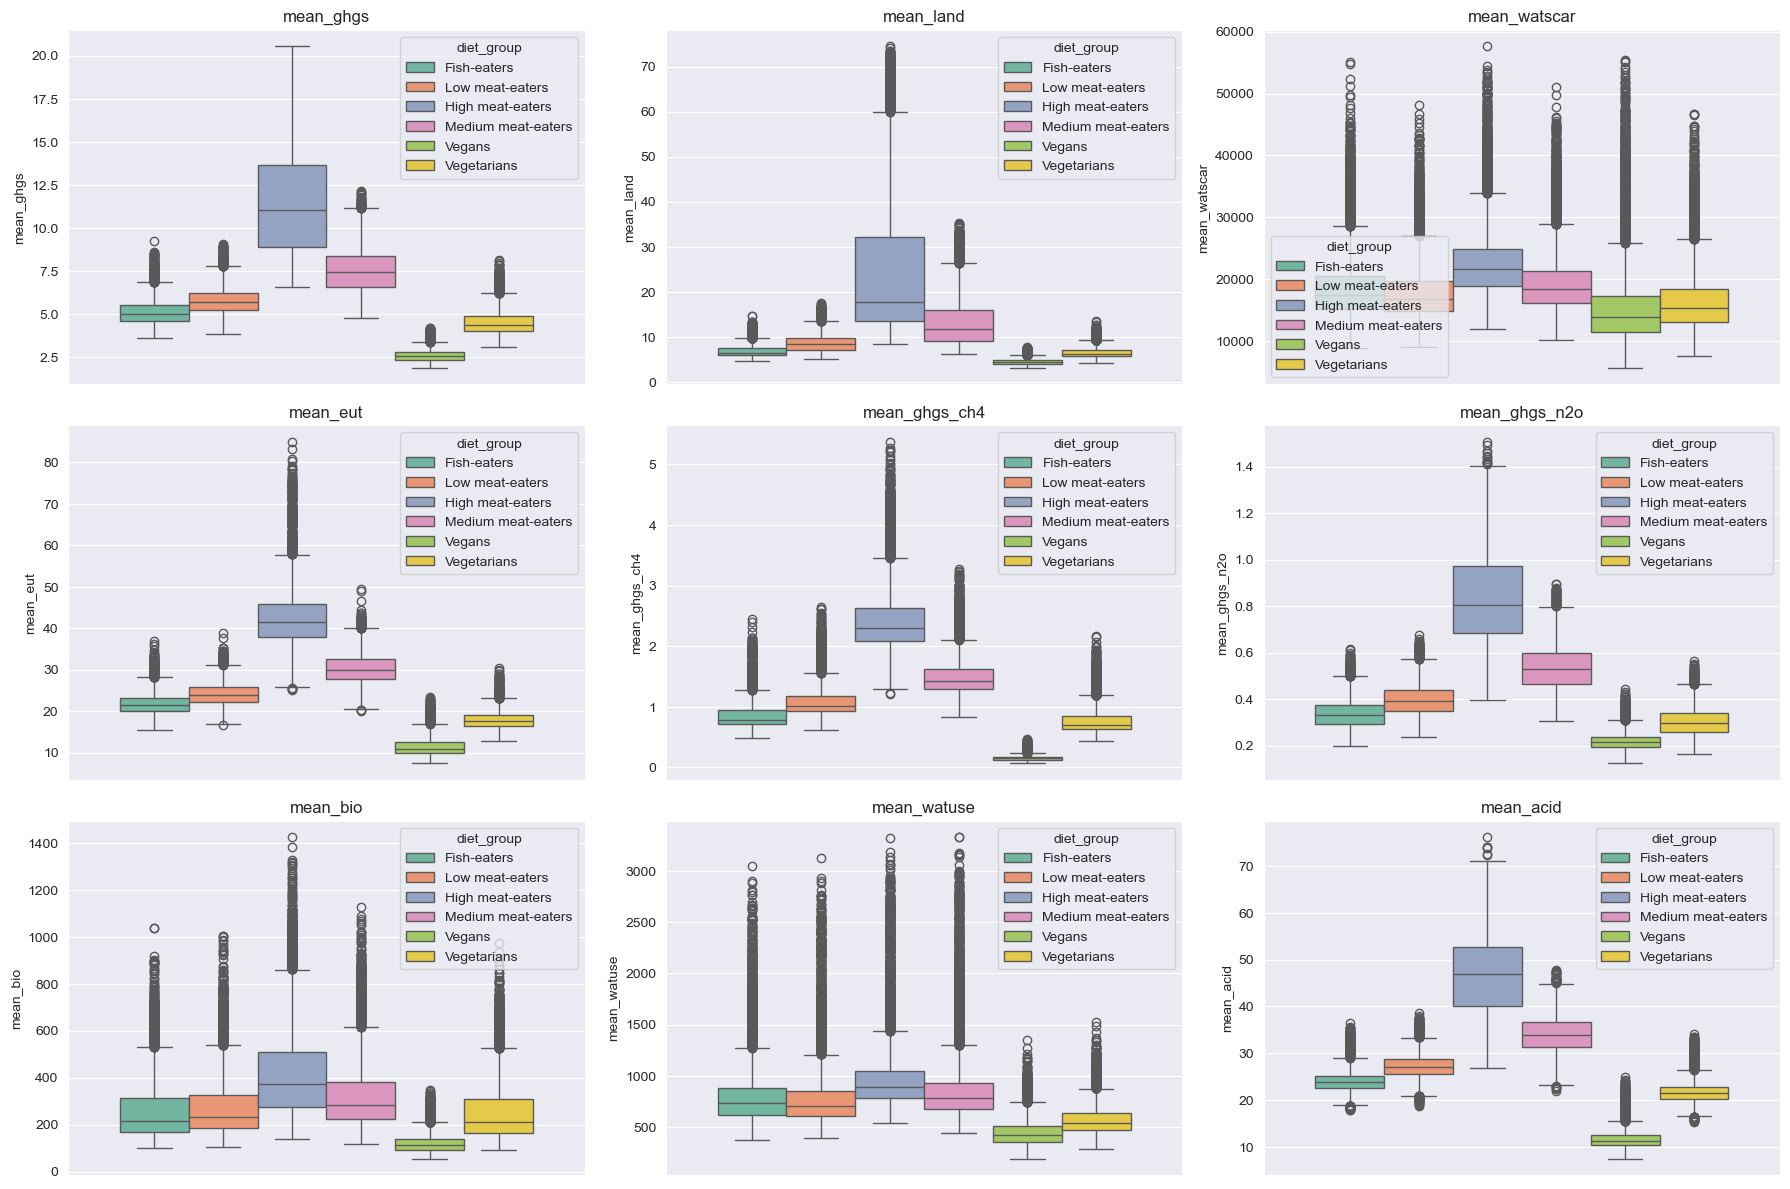

In [46]:
# Boxplot

variables_to_plot = [
    'mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut',
    'mean_ghgs_ch4', 'mean_ghgs_n2o', 'mean_bio', 'mean_watuse',
    'mean_acid'
]

n_cols = 3
n_rows = (len(variables_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    sns.boxplot(
        data=all_df,
        hue='diet_group',
        y=var,
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(var)
    axes[i].tick_params(axis='x', rotation=45)

# 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

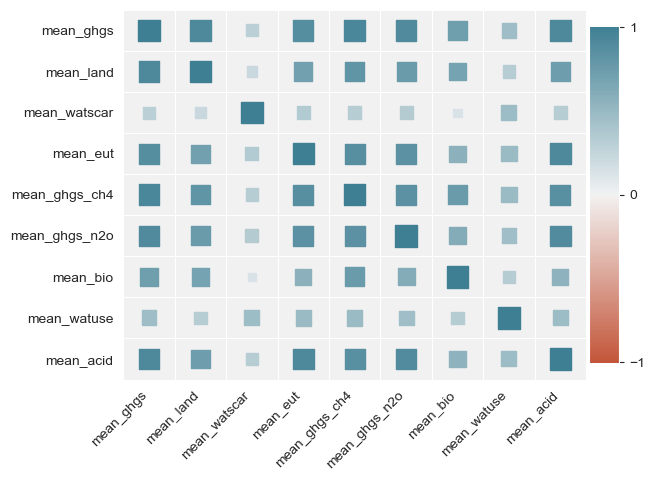

In [47]:
# Heatmap
# Reference: https://github.com/drazenz/heatmaps/blob/master/heatmap/heatmap.py
!pip install heatmapz
from heatmap import corrplot

df_numeric = clean_df.select_dtypes(include=[np.number]).copy()

cols_to_drop = [
    'n_participants',
    'sex',
    'diet_group',
    'age_group'
] + [col for col in df_numeric.columns if col.startswith('sd_')]

df_environmentIndex = df_numeric.drop(columns=cols_to_drop, errors="ignore") 

corrplot(df_environmentIndex.corr(), size_scale=240)


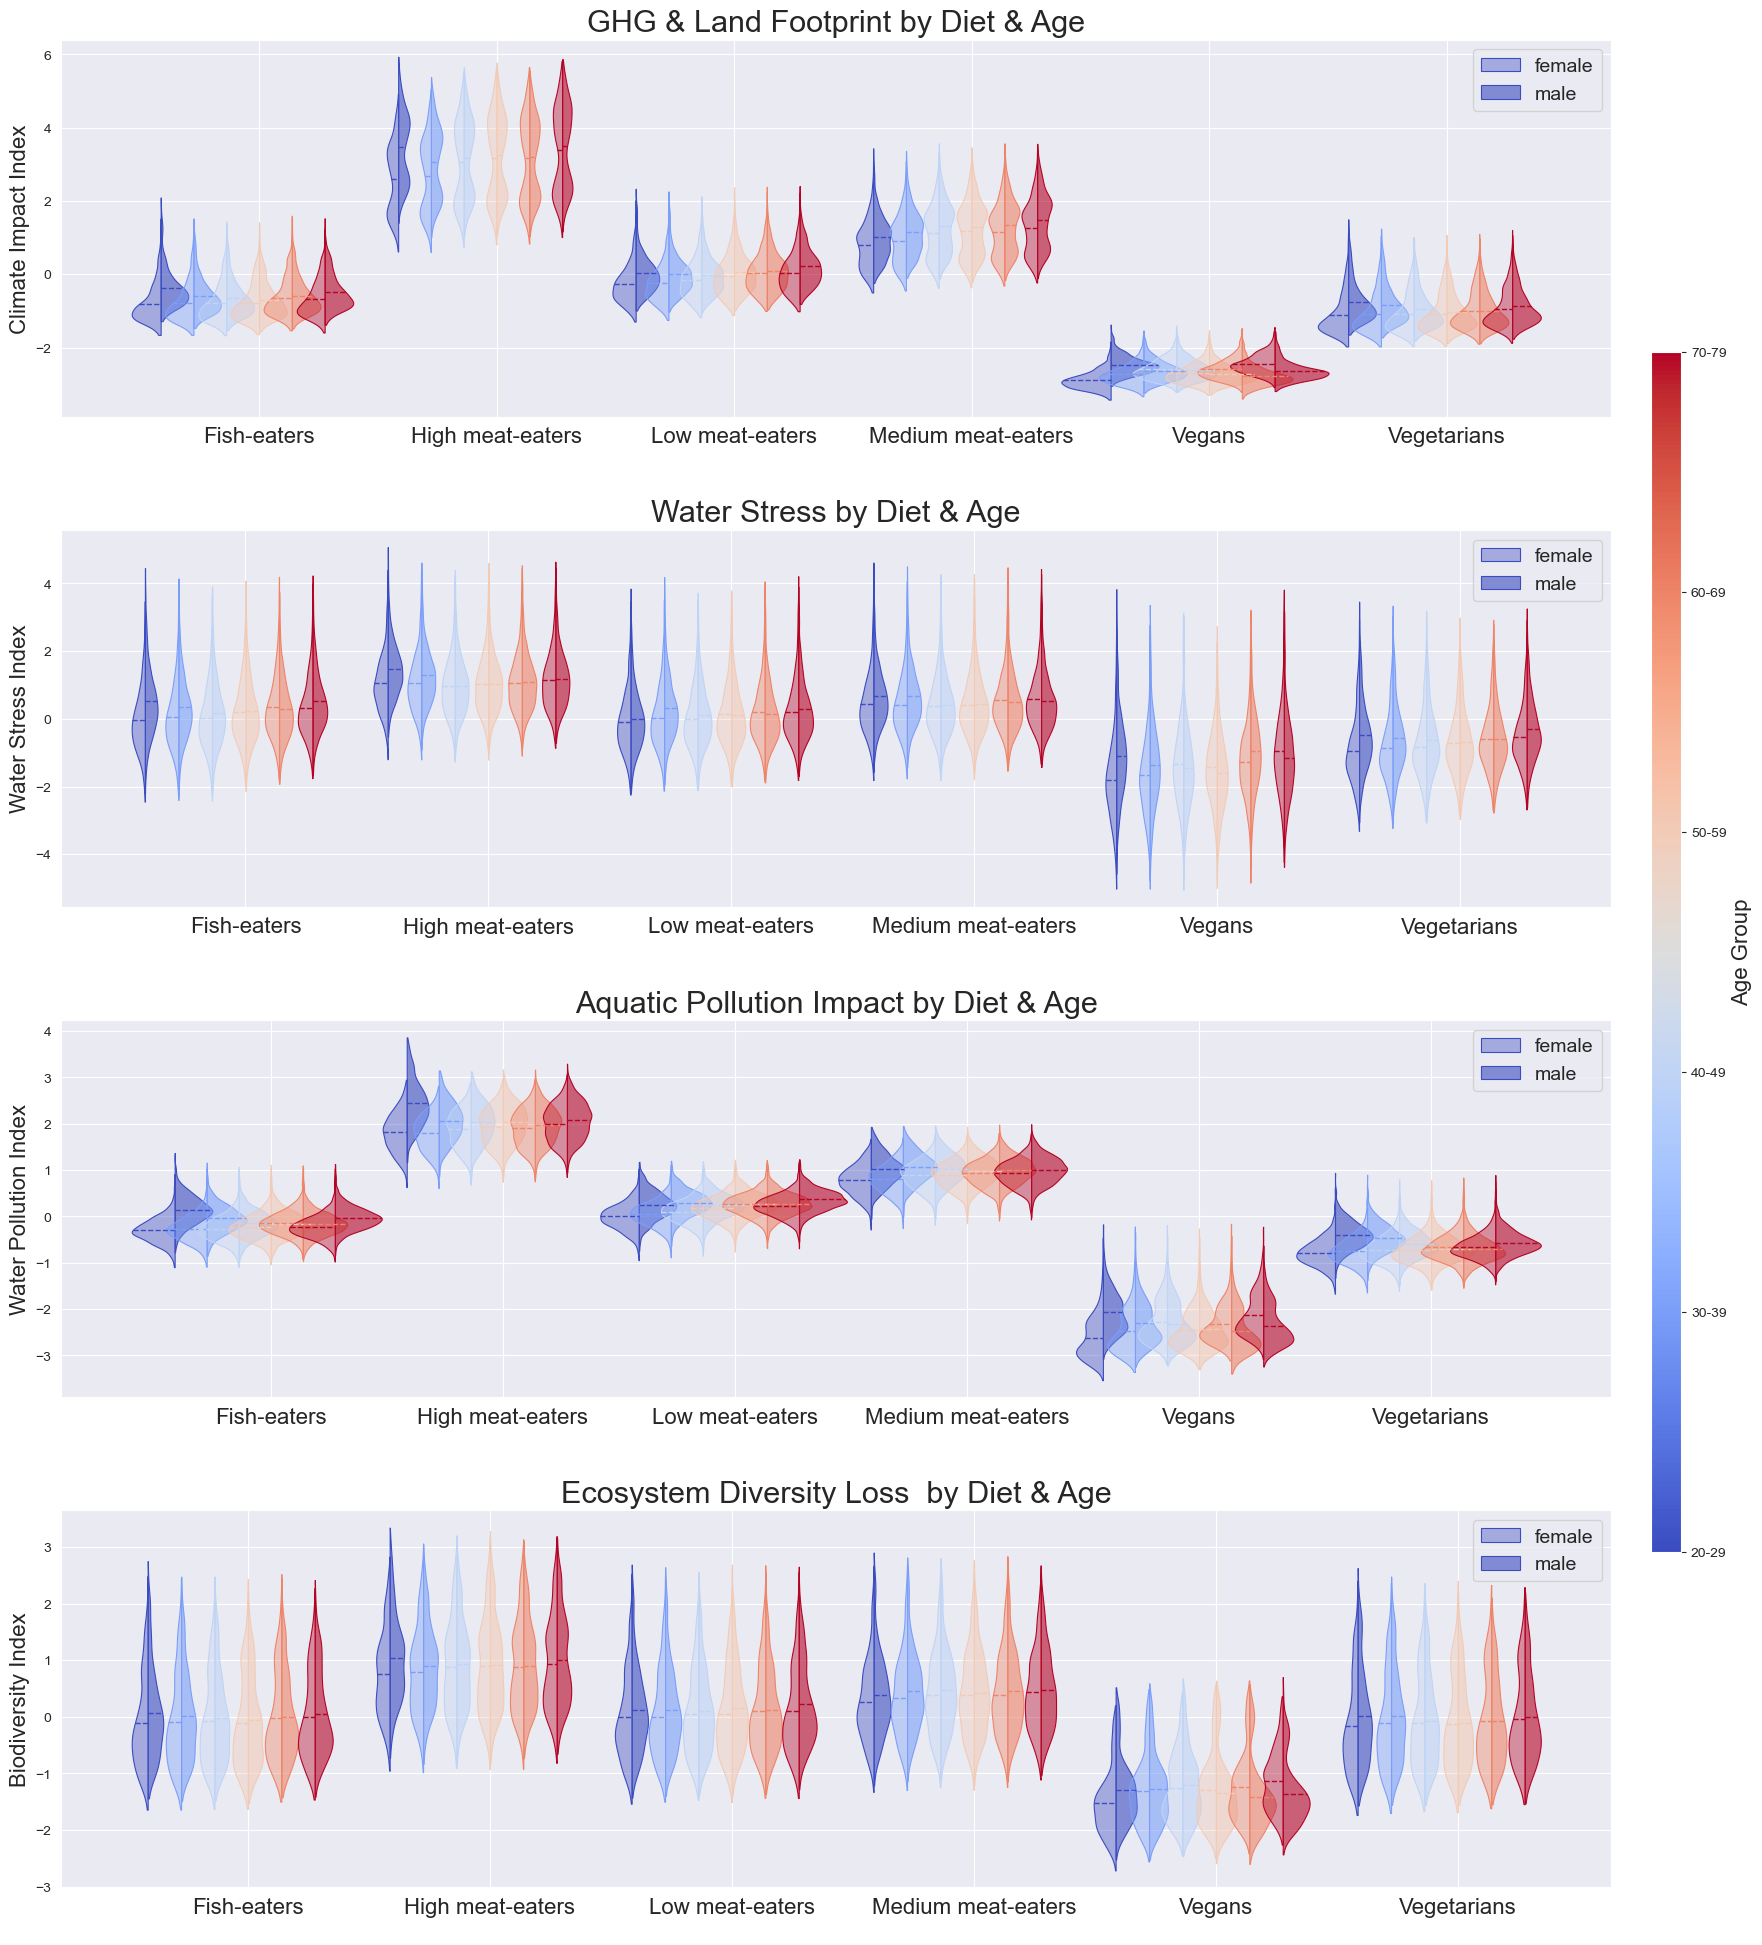

In [52]:
# violin Map
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib import colormaps
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable 

diet_groups = clean_df['diet_group'].unique()
num_groups = len(diet_groups)

df_log = clean_df.copy()

log_vars = [
    'mean_ghgs', 'mean_land', 'mean_ghgs_ch4', 'mean_ghgs_n2o',
    'mean_watscar', 'mean_watuse',
    'mean_acid', 'mean_eut',
    'mean_bio'
]
for var in log_vars:
     df_log[var] = np.log1p(df_log[var])
# ---------------pca
def pca_single_component(df_subset):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_subset)
    pca = PCA(n_components=1)
    component = pca.fit_transform(X_scaled)
    return component[:, 0] 

df_log['climate_impact_index'] = pca_single_component(df_log[['mean_ghgs', 'mean_land', 'mean_ghgs_ch4', 'mean_ghgs_n2o']])
df_log['water_stress_index'] = pca_single_component(df_log[['mean_watscar', 'mean_watuse']])
df_log['water_pollution_index'] = pca_single_component(df_log[['mean_acid', 'mean_eut']])
scaler = StandardScaler()
df_log['biodiversity_index'] = scaler.fit_transform(df_log[['mean_bio']])
#------------------ pca

simplified_df = df_log[['diet_group', 'age_group','sex', 'climate_impact_index', 'water_stress_index', 'water_pollution_index', 'biodiversity_index']]
violin_vars=['climate_impact_index', 'water_stress_index', 'water_pollution_index', 'biodiversity_index']

age_order = sorted(simplified_df['age_group'].unique())
diet_order = sorted(simplified_df['diet_group'].unique())
simplified_metrics = ['climate_impact_index', 'water_stress_index', 'water_pollution_index', 'biodiversity_index']

subplot_labels = {
    "climate_impact_index": "GHG & Land Footprint",
    "water_stress_index": "Water Stress",
    "water_pollution_index": "Aquatic Pollution Impact",
    "biodiversity_index": "Ecosystem Diversity Loss "
}

#  Color Mapping
cmap =colormaps["coolwarm"]
norm = mcolors.Normalize(vmin=0, vmax=len(age_order) - 1)  

edge_alpha = 0.6
edge_color_rgba = mcolors.to_rgba('black', alpha=edge_alpha)

# Violin Scale and group distance  
group_spacing = 4.2             
within_group_offset = 0.58      
width_scale = 0.5               

fig, axes = plt.subplots(4, 1, figsize=(20, 24), gridspec_kw={'wspace': 0.0, 'hspace': 0.3})
axes = axes.flatten()

# Subplot
for idx, metric in enumerate(simplified_metrics):
    ax = axes[idx]
    x_ticks = []
    x_labels = []

    for d_idx, diet in enumerate(diet_order):
        sub_df = simplified_df[simplified_df['diet_group'] == diet]
        group_center = d_idx * group_spacing

        for a_idx, age in enumerate(age_order):
            age_df = sub_df[sub_df['age_group'] == age]
            females = age_df[age_df['sex'] == 'female'][metric].dropna()
            males = age_df[age_df['sex'] == 'male'][metric].dropna()
            offset = (a_idx - len(age_order)/2) * within_group_offset
            x = group_center + offset

            base_color = cmap(norm(a_idx))
            female_color = mcolors.to_rgba(base_color, alpha=0.4)
            male_color = mcolors.to_rgba(base_color, alpha=0.6) 
            edge_color = mcolors.to_rgba(base_color, alpha=1.0)

            if len(females) > 1:
                kde_f = gaussian_kde(females)
                y = np.linspace(females.min(), females.max(), 200)
                ax.fill_betweenx(y, x - kde_f(y) * width_scale, x,
                                 facecolor=female_color, 
                                 linewidth=0.8,edgecolor=edge_color,
                                 label='female' if d_idx == 0 and a_idx == 0 else "")
                
                mean_f = females.mean()
                ax.hlines(mean_f, x - kde_f(mean_f) * width_scale, x,
                          colors=edge_color, linewidth=1, linestyles='--', zorder=5)

            if len(males) > 1:
                kde_m = gaussian_kde(males)
                y = np.linspace(males.min(), males.max(), 200)
                ax.fill_betweenx(y, x, x + kde_m(y) * width_scale,
                                 facecolor=male_color, 
                                 linewidth=0.8, edgecolor=edge_color,
                                 label='male' if d_idx == 0 and a_idx == 0 else "")
                mean_m = males.mean()
                ax.hlines(mean_m, x, x + kde_m(mean_m) * width_scale,
                          colors=edge_color, linewidth=1, linestyles='--', zorder=5)

        x_ticks.append(group_center)
        x_labels.append(diet)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,  ha='center', fontsize=16)
    # ax.set_title(f"{metric.replace('_', ' ').title()} by Diet & Age", fontsize=22)
    ax.set_title(f"{subplot_labels[metric]} by Diet & Age", fontsize=22)
    ax.set_xlabel(" ")
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=16)
    ax.legend(loc="upper right", fontsize=14)

# Color Bar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Age Group', fontsize=16)
cbar.set_ticks(np.arange(len(age_order)))
cbar.set_ticklabels(age_order)

plt.subplots_adjust(right=0.9)
plt.show()